# STEP 0 – Imports & Config

In [1]:


import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Optional: XGBoost (install if needed)
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

import joblib

OUTPUT_DIR = "outputs_student_dropout"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Saving all plots & files to:", OUTPUT_DIR)


Saving all plots & files to: outputs_student_dropout


# STEP 1 – Data Collection & Loading

In [2]:
DATA_PATH = "student dropout.csv"
df = pd.read_csv(DATA_PATH)
print("Shape",df.shape)
df.head()

Shape (649, 34)


,School,Gender,Age,Address,Family_Size,Parental_Status,Mother_Education,Father_Education,Mother_Job,Father_Job,...,Free_Time,Going_Out,Weekend_Alcohol_Consumption,Weekday_Alcohol_Consumption,Health_Status,Number_of_Absences,Grade_1,Grade_2,Final_Grade,Dropped_Out
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,False
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,False
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,False
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,False
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,False


# STEP 2 – Basic Info & Missing Values

In [3]:
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)

print("\nMissing values per column:\n", df.isnull().sum())

print("\nTarget (Dropped_Out) value counts:\n", df["Dropped_Out"].value_counts())

Columns: ['School', 'Gender', 'Age', 'Address', 'Family_Size', 'Parental_Status', 'Mother_Education', 'Father_Education', 'Mother_Job', 'Father_Job', 'Reason_for_Choosing_School', 'Guardian', 'Travel_Time', 'Study_Time', 'Number_of_Failures', 'School_Support', 'Family_Support', 'Extra_Paid_Class', 'Extra_Curricular_Activities', 'Attended_Nursery', 'Wants_Higher_Education', 'Internet_Access', 'In_Relationship', 'Family_Relationship', 'Free_Time', 'Going_Out', 'Weekend_Alcohol_Consumption', 'Weekday_Alcohol_Consumption', 'Health_Status', 'Number_of_Absences', 'Grade_1', 'Grade_2', 'Final_Grade', 'Dropped_Out']

Data types:
 School                         object
Gender                         object
Age                             int64
Address                        object
Family_Size                    object
Parental_Status                object
Mother_Education                int64
Father_Education                int64
Mother_Job                     object
Father_Job                  

# STEP 3 – EDA: Target + Numeric Distributions

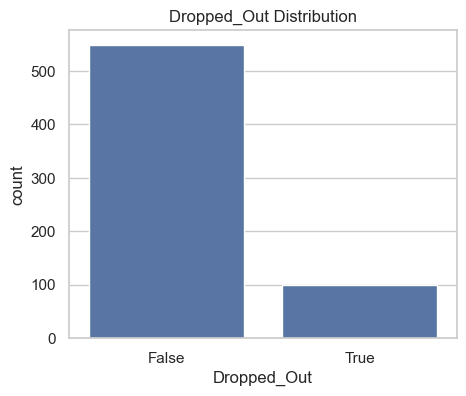

Numeric columns: ['Age', 'Mother_Education', 'Father_Education', 'Travel_Time', 'Study_Time', 'Number_of_Failures', 'Family_Relationship', 'Free_Time', 'Going_Out', 'Weekend_Alcohol_Consumption', 'Weekday_Alcohol_Consumption', 'Health_Status', 'Number_of_Absences', 'Grade_1', 'Grade_2', 'Final_Grade']


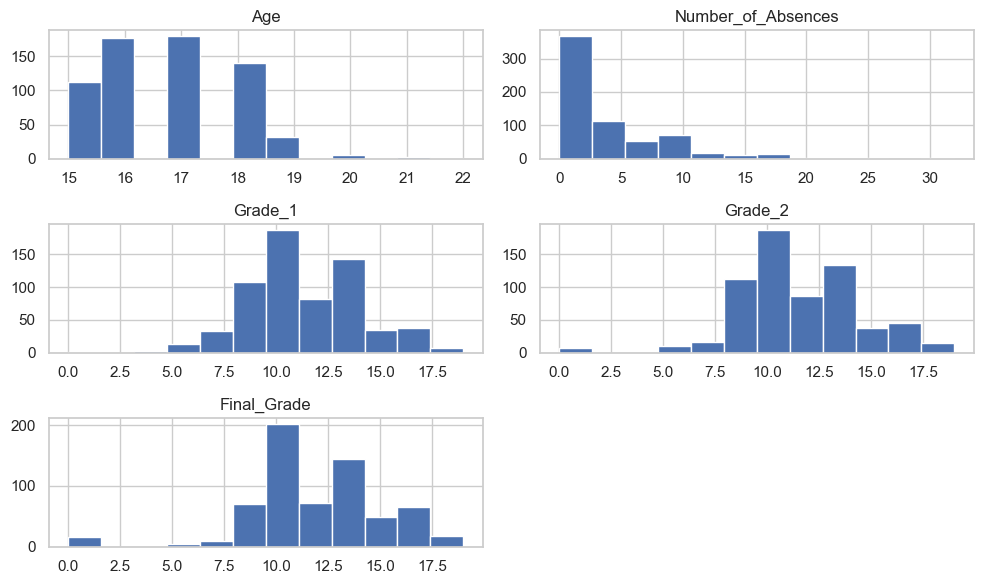

In [4]:
# STEP 3: EDA - target and numeric distributions

sns.set(style="whitegrid")

# Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x="Dropped_Out", data=df)
plt.title("Dropped_Out Distribution")
plt.savefig(os.path.join(OUTPUT_DIR, "target_distribution.png"), bbox_inches="tight")
plt.show()

# Numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

# Histograms of important numeric columns
important_num = [c for c in ["Age","Number_of_Absences","Grade_1","Grade_2","Final_Grade"] if c in num_cols]

df[important_num].hist(bins=12, figsize=(10,6))
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "numeric_histograms.png"), bbox_inches="tight")
plt.show()


# STEP 4 – EDA: Categorical & Heatmap

Categorical columns: ['School', 'Gender', 'Address', 'Family_Size', 'Parental_Status', 'Mother_Job', 'Father_Job', 'Reason_for_Choosing_School', 'Guardian', 'School_Support', 'Family_Support', 'Extra_Paid_Class', 'Extra_Curricular_Activities', 'Attended_Nursery', 'Wants_Higher_Education', 'Internet_Access', 'In_Relationship']


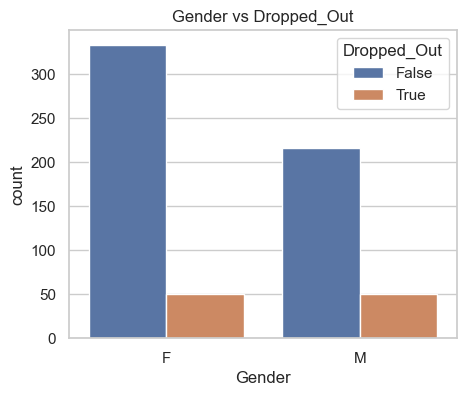

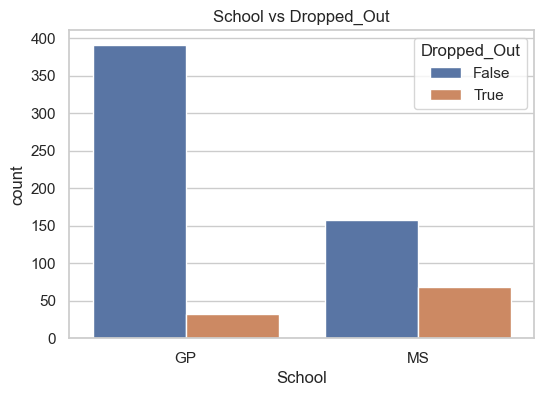

In [ ]:
# STEP 4: EDA - categorical plots & correlation heatmap

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)

# 1) Gender vs Dropped_Out
if "Gender" in df.columns:
    plt.figure(figsize=(5,4))
    sns.countplot(x="Gender", hue="Dropped_Out", data=df)
    plt.title("Gender vs Dropped_Out")
    plt.savefig(os.path.join(OUTPUT_DIR, "gender_vs_target.png"), bbox_inches="tight")
    plt.show()

# 2) School vs Dropped_Out
if "School" in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x="School", hue="Dropped_Out", data=df)
    plt.title("School vs Dropped_Out")
    plt.savefig(os.path.join(OUTPUT_DIR, "school_vs_target.png"), bbox_inches="tight")
    plt.show()

# 3) Boxplot: Final_Grade vs Dropped_Out
if "Final_Grade" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Dropped_Out", y="Final_Grade", data=df)
    plt.title("Final Grade by Dropped_Out")
    plt.savefig(os.path.join(OUTPUT_DIR, "finalgrade_vs_target.png"), bbox_inches="tight")
    plt.show()

# 4) Correlation heatmap for numeric variables
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    corr = df[num_cols].corr()
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.savefig(os.path.join(OUTPUT_DIR, "correlation_heatmap.png"), bbox_inches="tight")
    plt.show()


# STEP 5 – Preprocessing & Cleaning 

In [6]:
# STEP 5: Preprocessing & cleaning

df_clean = df.copy()

# Encode target Dropped_Out -> 0/1
le_target = LabelEncoder()
df_clean["Dropped_Out_enc"] = le_target.fit_transform(df_clean["Dropped_Out"])
print("Target classes (0/1 mapping):", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))


Target classes (0/1 mapping): {np.False_: np.int64(0), np.True_: np.int64(1)}


# STEP 6 – Feature Engineering

In [8]:
# STEP 6: Feature Engineering

df_fe = df_clean.copy()

# 1) Average of Grade_1 and Grade_2
if {"Grade_1","Grade_2"}.issubset(df_fe.columns):
    df_fe["Grade_Avg"] = (df_fe["Grade_1"] + df_fe["Grade_2"]) / 2

# 2) High absence flag
if "Number_of_Absences" in df_fe.columns:
    median_abs = df_fe["Number_of_Absences"].median()
    df_fe["High_Absence"] = (df_fe["Number_of_Absences"] > median_abs).astype(int)

# 3) Alcohol total consumption (weekend + weekday)
if {"Weekend_Alcohol_Consumption","Weekday_Alcohol_Consumption"}.issubset(df_fe.columns):
    df_fe["Total_Alcohol"] = (
        df_fe["Weekend_Alcohol_Consumption"] +
        df_fe["Weekday_Alcohol_Consumption"]
    )

# Show some engineered columns
cols_show = [c for c in ["Grade_Avg","High_Absence","Total_Alcohol"] if c in df_fe.columns]
df_fe[cols_show + ["Dropped_Out"]].head()


,Grade_Avg,High_Absence,Total_Alcohol,Dropped_Out
0,5.5,1,2,False
1,10.0,0,2,False
2,12.5,1,5,False
3,14.0,0,2,False
4,12.0,0,3,False


# STEP 7 – Feature Selection

In [9]:
# STEP 7: Select features for modeling (manual selection)

selected_features = []

# Important numeric
for col in ["Age","Mother_Education","Father_Education",
            "Number_of_Absences","Grade_1","Grade_2","Final_Grade",
            "Grade_Avg","High_Absence","Total_Alcohol"]:
    if col in df_fe.columns:
        selected_features.append(col)

# Important categorical
for col in ["School","Gender","Address","Family_Size","Parental_Status",
            "Mother_Job","Father_Job","Reason_for_Choosing_School"]:
    if col in df_fe.columns:
        selected_features.append(col)

print("Selected features:", selected_features)

X = df_fe[selected_features].copy()
y = df_fe["Dropped_Out_enc"].copy()


Selected features: ['Age', 'Mother_Education', 'Father_Education', 'Number_of_Absences', 'Grade_1', 'Grade_2', 'Final_Grade', 'Grade_Avg', 'High_Absence', 'Total_Alcohol', 'School', 'Gender', 'Address', 'Family_Size', 'Parental_Status', 'Mother_Job', 'Father_Job', 'Reason_for_Choosing_School']


# STEP 8 – Build Preprocessing (OneHot + Scaling)

In [11]:
# STEP 8: Preprocessing pipeline (for X only)

num_cols_final = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_final = [c for c in X.columns if c not in num_cols_final]

print("Numeric features:", num_cols_final)
print("Categorical features:", cat_cols_final)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_final),
        ("cat", categorical_transformer, cat_cols_final)
    ]
)

# Fit on whole X to get feature space
X_processed = preprocessor.fit_transform(X)
print("Processed X shape:", X_processed.shape)


Numeric features: ['Age', 'Mother_Education', 'Father_Education', 'Number_of_Absences', 'Grade_1', 'Grade_2', 'Final_Grade', 'Grade_Avg', 'High_Absence', 'Total_Alcohol']
Categorical features: ['School', 'Gender', 'Address', 'Family_Size', 'Parental_Status', 'Mother_Job', 'Father_Job', 'Reason_for_Choosing_School']
Processed X shape: (649, 34)


#  STEP 9 – Train/Test Split

In [12]:
# STEP 9: Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train class balance:", np.bincount(y_train))
print("Test class balance:", np.bincount(y_test))


Train shape: (519, 34)
Test shape: (130, 34)
Train class balance: [439  80]
Test class balance: [110  20]


# STEP 10 – Define Models

In [13]:
# STEP 10: Model definitions

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, class_weight="balanced", random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(
        random_state=42, class_weight="balanced"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=20, random_state=42,
        class_weight="balanced", n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced",
        random_state=42
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

if XGB_AVAILABLE:
    models["XGBoost"] = xgb.XGBClassifier(
        use_label_encoder=False, eval_metric="logloss", random_state=42
    )

print("Models:", list(models.keys()))


Models: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'SVM', 'KNN', 'XGBoost']


#  STEP 11 – Train & Evaluate All Models


MODEL: LogisticRegression
Accuracy: 0.9308
ROC AUC: 0.9827

Classification report:
               precision    recall  f1-score   support

       False       0.98      0.94      0.96       110
        True       0.72      0.90      0.80        20

    accuracy                           0.93       130
   macro avg       0.85      0.92      0.88       130
weighted avg       0.94      0.93      0.93       130

Confusion matrix:
 [[103   7]
 [  2  18]]


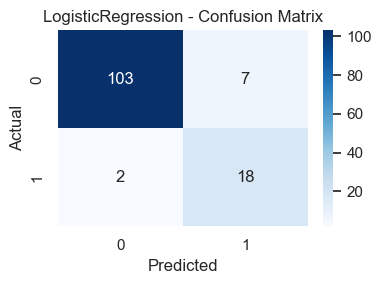


MODEL: DecisionTree
Accuracy: 1.0
ROC AUC: 1.0

Classification report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       110
        True       1.00      1.00      1.00        20

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130

Confusion matrix:
 [[110   0]
 [  0  20]]


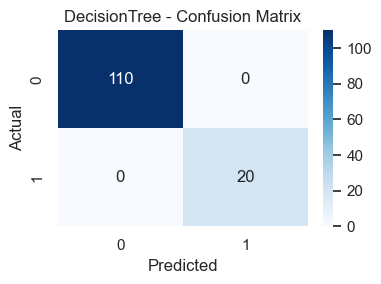


MODEL: RandomForest
Accuracy: 0.9923
ROC AUC: 1.0

Classification report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00       110
        True       1.00      0.95      0.97        20

    accuracy                           0.99       130
   macro avg       1.00      0.97      0.98       130
weighted avg       0.99      0.99      0.99       130

Confusion matrix:
 [[110   0]
 [  1  19]]


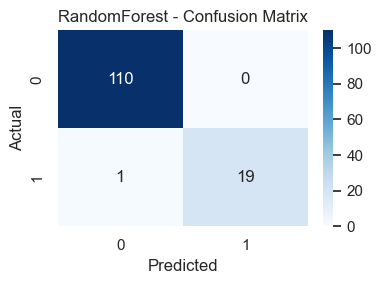


MODEL: SVM
Accuracy: 0.9231
ROC AUC: 0.9723

Classification report:
               precision    recall  f1-score   support

       False       0.99      0.92      0.95       110
        True       0.68      0.95      0.79        20

    accuracy                           0.92       130
   macro avg       0.83      0.93      0.87       130
weighted avg       0.94      0.92      0.93       130

Confusion matrix:
 [[101   9]
 [  1  19]]


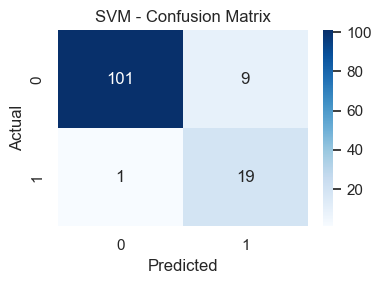


MODEL: KNN
Accuracy: 0.9231
ROC AUC: 0.9436

Classification report:
               precision    recall  f1-score   support

       False       0.94      0.97      0.96       110
        True       0.81      0.65      0.72        20

    accuracy                           0.92       130
   macro avg       0.88      0.81      0.84       130
weighted avg       0.92      0.92      0.92       130

Confusion matrix:
 [[107   3]
 [  7  13]]


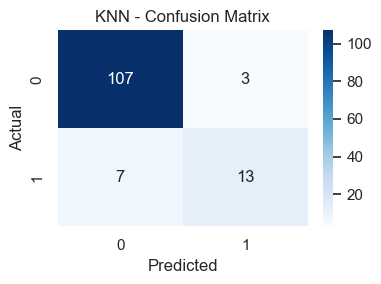


MODEL: XGBoost
Accuracy: 1.0
ROC AUC: 1.0

Classification report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       110
        True       1.00      1.00      1.00        20

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130

Confusion matrix:
 [[110   0]
 [  0  20]]


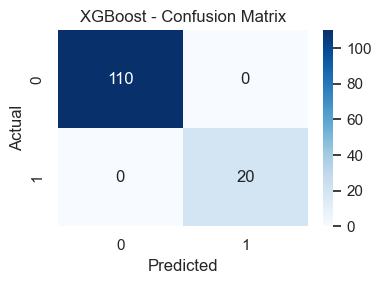

In [15]:
# STEP 11: Train & evaluate each model

results = []

for name, model in models.items():
    print("\n==============================")
    print("MODEL:", name)
    print("==============================")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For models without predict_proba (rare here), use decision_function
        if hasattr(model, "decision_function"):
            d = model.decision_function(X_test)
            y_proba = (d - d.min()) / (d.max() - d.min() + 1e-8)
        else:
            y_proba = np.zeros_like(y_test, dtype=float)
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print("Accuracy:", round(acc, 4))
    print("ROC AUC:", round(roc_auc, 4))
    print("\nClassification report:\n", classification_report(
        y_test, y_pred, target_names=[str(c) for c in le_target.classes_]
    ))
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    
    # Save confusion matrix heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{name}_confusion_matrix.png"),
                bbox_inches="tight")
    plt.show()
    
    results.append((name, acc, roc_auc))


# STEP 12 – Compare Models & Pick Best

In [16]:
# STEP 12: Model comparison summary

results_df = pd.DataFrame(results, columns=["Model","Accuracy","ROC_AUC"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)

results_df.to_csv(os.path.join(OUTPUT_DIR, "model_comparison.csv"), index=False)

best_model_name = results_df.iloc[0]["Model"]
print("\nBest model by Accuracy:", best_model_name)
best_model = models[best_model_name]


                Model  Accuracy   ROC_AUC
1        DecisionTree  1.000000  1.000000
5             XGBoost  1.000000  1.000000
2        RandomForest  0.992308  1.000000
0  LogisticRegression  0.930769  0.982727
3                 SVM  0.923077  0.972273
4                 KNN  0.923077  0.943636

Best model by Accuracy: DecisionTree


# STEP 13 – ROC Curve for Best Model

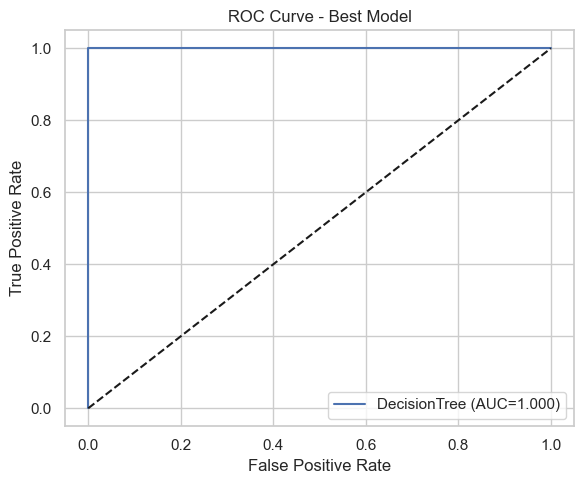

In [17]:
# STEP 13: ROC curve for best model

if hasattr(best_model, "predict_proba"):
    y_proba_best = best_model.predict_proba(X_test)[:, 1]
else:
    d = best_model.decision_function(X_test)
    y_proba_best = (d - d.min()) / (d.max() - d.min() + 1e-8)

fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc_best = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={roc_auc_best:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best Model")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"{best_model_name}_ROC_curve.png"),
            bbox_inches="tight")
plt.show()


# STEP 14 – Feature Importance (Random Forest)

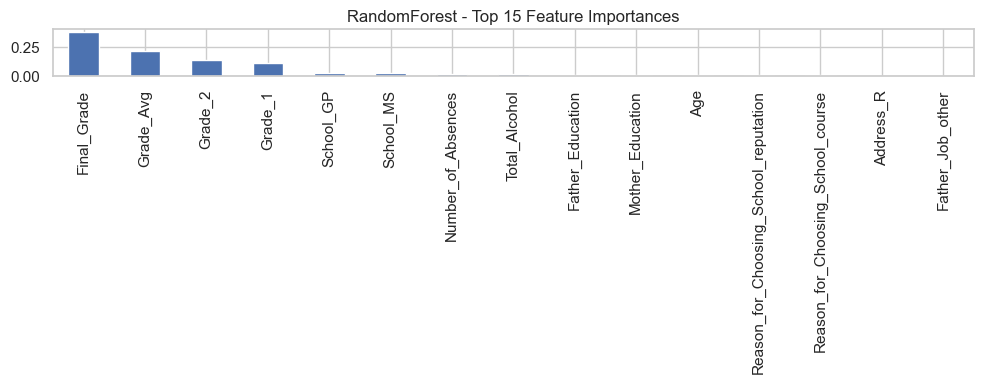

Top 15 Features:
 Final_Grade                              0.377588
Grade_Avg                                0.216643
Grade_2                                  0.133066
Grade_1                                  0.109690
School_GP                                0.024347
School_MS                                0.021772
Number_of_Absences                       0.013980
Total_Alcohol                            0.012941
Father_Education                         0.011101
Mother_Education                         0.009488
Age                                      0.009179
Reason_for_Choosing_School_reputation    0.005000
Reason_for_Choosing_School_course        0.004454
Address_R                                0.003419
Father_Job_other                         0.003416
dtype: float64


In [18]:
# STEP 14: Feature importance from RandomForest

if "RandomForest" in models:
    rf_model = models["RandomForest"]
    
    # rebuild feature names for processed matrix
    num_names = num_cols_final
    try:
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_names = list(ohe.get_feature_names_out(cat_cols_final))
    except Exception:
        cat_names = [f"cat_{i}" for i in range(X_processed.shape[1]-len(num_names))]
    all_feature_names = num_names + cat_names
    
    importances = rf_model.feature_importances_
    fi = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
    
    plt.figure(figsize=(10,4))
    fi.head(15).plot(kind="bar")
    plt.title("RandomForest - Top 15 Feature Importances")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "RF_feature_importance.png"),
                bbox_inches="tight")
    plt.show()
    
    print("Top 15 Features:\n", fi.head(15))


# STEP 15 – Hyperparameter Tuning (Random Forest, small but research-level)

In [19]:
# STEP 15: Hyperparameter tuning for RandomForest (small grid)

param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 2],
    "min_samples_split": [2, 5]
}

rf_base = RandomForestClassifier(
    random_state=42, class_weight="balanced", n_jobs=-1
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    rf_base, param_grid,
    scoring="roc_auc", cv=cv, n_jobs=1, verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)

rf_tuned = grid_rf.best_estimator_

y_pred_tuned = rf_tuned.predict(X_test)
y_proba_tuned = rf_tuned.predict_proba(X_test)[:,1]

print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned RF ROC AUC:", roc_auc_score(y_test, y_proba_tuned))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best RF params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned RF Accuracy: 0.9923076923076923
Tuned RF ROC AUC: 1.0


# STEP 16 – Final Prediction & Save Model

In [20]:
# STEP 16: Final model & prediction function

# choose tuned RF as final model (if tuning done), else best_model
final_model = rf_tuned if "rf_tuned" in globals() else best_model

# Save preprocessor and model
joblib.dump(preprocessor, os.path.join(OUTPUT_DIR, "preprocessor.joblib"))
joblib.dump(final_model, os.path.join(OUTPUT_DIR, "final_model.joblib"))
print("Saved preprocessor and final model to:", OUTPUT_DIR)

# Helper function for predicting new student(s)
def predict_new_students(df_new_raw: pd.DataFrame):
    """
    df_new_raw: DataFrame with SAME columns as original df_fe[selected_features]
    Returns predicted class label (False/True) and dropout probability.
    """
    X_new = df_new_raw[selected_features].copy()
    X_new_proc = preprocessor.transform(X_new)
    y_new_pred = final_model.predict(X_new_proc)
    y_new_proba = final_model.predict_proba(X_new_proc)[:,1]
    # convert 0/1 -> original labels
    labels = le_target.inverse_transform(y_new_pred)
    return labels, y_new_proba

# Example: predict for the first row
example = df_fe.iloc[[0]][selected_features]
print("Example row:\n", example)
pred_label, pred_prob = predict_new_students(example)
print("Predicted Dropped_Out:", pred_label[0], "Probability:", pred_prob[0])


Saved preprocessor and final model to: outputs_student_dropout
Example row:
    Age  Mother_Education  Father_Education  Number_of_Absences  Grade_1  \
0   18                 4                 4                   4        0   

   Grade_2  Final_Grade  Grade_Avg  High_Absence  Total_Alcohol School Gender  \
0       11           11        5.5             1              2     GP      F   

  Address Family_Size Parental_Status Mother_Job Father_Job  \
0       U         GT3               A    at_home    teacher   

  Reason_for_Choosing_School  
0                     course  
Predicted Dropped_Out: False Probability: 0.055
